In [8]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [9]:
train  = pd.read_csv('../competition_data/train.csv')
test  = pd.read_csv('../competition_data/test.csv')
## Input Feature - Target 분리
##train_x = train.drop(['nerdiness', 'index'],axis=1)   ## Input Feature 값
##train_y = train['nerdiness']     

In [10]:
## Test 문항에 대한 Column
test_cols = ['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10',
             'Q11','Q12','Q13','Q14','Q15','Q16','Q17','Q18','Q19','Q20',
             'Q21','Q22', 'Q23','Q24','Q25','Q26']

## 응시 시간 문항에 대한 Column
time_cols = ['introelapse', 'testelapse', 'surveyelapse']

## TIPI 문항에 대한 Column
tipi_cols = ['TIPI1','TIPI2','TIPI3','TIPI4','TIPI5','TIPI6','TIPI7','TIPI8',
             'TIPI9','TIPI10']

vcl_exist = ['VCL1','VCL2','VCL3','VCL4','VCL5','VCL7','VCL8','VCL10','VCL11','VCL13','VCL14','VCL15','VCL16']
vcl_no_exist = ['VCL6','VCL9','VCL12']
## VCL 문항에 대한 Column
vcl_cols = vcl_exist + vcl_no_exist

## 설문문항에 대한 Column
survy_cols = ['country','education','urban','gender','engnat','age','hand','religion',
              'orientation','voted','married','familysize','ASD']

+ 2 개 이상의 존재하지 않는 단어를 안다고 응답한 사람들 또는, testelapse, surveyelapse 가 매우 짧은 사람들의 경우, 신뢰도가 떨어지므로, 해당 Row 들 모두 삭제
+ (testelapse,surveyelapse) 에 결측치가 존재하는 경우, 1개 이하의 존재하지 않는 단어에 대해 안다고 응답한 경우에만, 결측치를 평균치로 대체


In [14]:
def delRows(dframe):
    tmp_frame = dframe.copy()
    
    tmp_frame['no_exist_know'] = tmp_frame[vcl_no_exist].sum(axis=1)    ## 존재하지 않는 단어들 중 안다고 응답한 단어의 개수 (no_exist_know 칼럼)
    tmp_frame = tmp_frame[tmp_frame['no_exist_know'] <= 1]              ## 존재하지 않는 단어들 중 안다고 응답한 단어가 1개 이하인 경우만 신뢰성 있다고 판단
    
    ## testelapse 하위0.04% 미만의 값을 갖는 Row 들 전부 삭제
    test_004q = tmp_frame['testelapse'].quantile(q=0.0004,interpolation='nearest') 
    tmp_frame=tmp_frame[tmp_frame['testelapse'] >= test_004q]

    ## surveyelapse 하위 0.2% 미만의 값을 갖는 Row 들 전부 삭제
    srvy_04q = tmp_frame['surveyelapse'].quantile(q=0.002,interpolation='nearest')
    tmp_frame=tmp_frame[tmp_frame['surveyelapse'] >= srvy_04q]
    
    ## 동시에, 7 세 이하(유아기)의 경우, 답변의 신뢰도가 적을 것이라 판단하여, 해당 Column들 제거
    tmp_frame = tmp_frame[tmp_frame['age'] > 7]

    ## no_exist_know 칼럼 drop
    tmp_frame= tmp_frame.drop(['no_exist_know'], axis=1)
    return tmp_frame

def subOutli(dframe):
    tmp_frame = dframe.copy()
    ## age 를 나이라고 판단했을 때, 100 이상의 값을 의미없는 이상치라 판단하여, 해당 이상치값들을 평균치로 변환
    tmp_frame.loc[tmp_frame['age'] >= 100, 'age'] = round(tmp_frame['age'].mean())
    ## 동시에, 7 세 이하(유아기)의 경우, 답변의 신뢰도가 적을 것이라 판단하여, 해당 Column들 제거
    ## familysize 를 응답자 본인을 포함한 형제자매의 수라고 판단했을 때, 39 이상의 값을 의미없는 이상치라 판단하여, 해당 이상치값들을 평균치로 변환
    tmp_frame.loc[tmp_frame['familysize']>=39,'familysize'] =  round(tmp_frame['familysize'].mean())
    
    return tmp_frame




def ratio_table(cross_tab):
    return cross_tab.div(cross_tab.sum(axis=1),axis='index')


def replaceNAN(dframe):
    continuous_nan = ['age','familysize','testelapse','surveyelapse']             ## 연속형 변수
    norminal_nan = list(set(dframe.columns.values).difference(set(continuous_nan + test_cols)))
    tmp_frame = dframe.copy()
    ## 연속형 변수들에 대해서는 평균값으로 대체
    tmp_frame[continuous_nan] = tmp_frame[continuous_nan].fillna(round(tmp_frame[continuous_nan].mean()))
    ## 이산형 변수들에 대해서는 최빈값으로 대체
    tmp_frame[norminal_nan] =tmp_frame[norminal_nan].fillna(tmp_frame[norminal_nan].mode().iloc[0].squeeze())
    ## 한편, Test 문항들에 대해서는 Row 기준 (Q1 ~ Q26) 최빈값으로 채워 넣음.
    freq_Qs = tmp_frame.mode(axis=1)[0]
    for t_col in test_cols:
        tmp_frame[t_col]= tmp_frame[t_col].fillna(freq_Qs)
    return tmp_frame


def cat_age(dframe):
    range_list = np.linspace(1.94,4.5,5)
    tmp_frame = dframe.copy()
    tmp_frame['age_log'] = np.log(tmp_frame['age'])
    
    tmp_frame['age_loggroup'] = 1
    tmp_frame.loc[(tmp_frame['age_log'] >= range_list[0]) & (tmp_frame['age_log'] < range_list[1]), 'age_loggroup'] = 0  ## 0 명 인 그룹     : 그룹 0
    tmp_frame.loc[(tmp_frame['age_log'] >= range_list[1]) & (tmp_frame['age_log'] < range_list[2]), 'age_loggroup'] = 1  ## 1 명 인 그룹     : 그룹 1
    tmp_frame.loc[(tmp_frame['age_log'] >= range_list[2]) & (tmp_frame['age_log'] < range_list[3]), 'age_loggroup'] = 2  ## 2 명 인 그룹     : 그룹 2 
    tmp_frame.loc[(tmp_frame['age_log'] >= range_list[3]) & (tmp_frame['age_log'] < range_list[4]), 'age_loggroup'] = 3  ## 3 명 인 그룹 
    
    tmp_frame =tmp_frame.drop(['age_log'],axis=1)
    
    return tmp_frame


def cat_familysize(dframe):
    tmp_frame = dframe.copy()
    tmp_frame['familysize_group'] = 1
    tmp_frame.loc[tmp_frame['familysize'] == 0, 'familysize_group'] = 0  ## 0 명 인 그룹     : 그룹 0
    tmp_frame.loc[tmp_frame['familysize'] == 1, 'familysize_group'] = 1  ## 1 명 인 그룹     : 그룹 1
    tmp_frame.loc[tmp_frame['familysize'] == 2, 'familysize_group'] = 2  ## 2 명 인 그룹     : 그룹 2 
    tmp_frame.loc[tmp_frame['familysize'] == 3, 'familysize_group'] = 3  ## 3 명 인 그룹     : 그룹 3  
    tmp_frame.loc[tmp_frame['familysize'] == 4, 'familysize_group'] = 4  ## 4 명 인 그룹     : 그룹 4 
    tmp_frame.loc[tmp_frame['familysize'] >= 5, 'familysize_group'] = 5  ## 5 명 이상인 그룹 : 그룹 5

    return tmp_frame


def groupCntryCol(dframe):
    tmp_country = train[['country','nerdiness']].dropna()
    native_country_table=tmp_country['country'].value_counts()
    country_count = tmp_country['country'].unique().shape[0]
    
    country_crosstab=pd.crosstab(tmp_country['country'],tmp_country['nerdiness'])
    country_crossgtab_res=ss.chi2_contingency(country_crosstab)
    
    country_ratio=ratio_table(country_crosstab)
    country_ratio=country_ratio.sort_values(by=0)
    
    prob_dict=dict(country_ratio[1])
    
    cntry_group1=[]
    cntry_group2=[]
    cntry_group3=[]
    cntry_group4=[]

    for country in tmp_country['country'].unique():
        country_data=tmp_country[tmp_country['country']==country]['nerdiness']
        probs=sum(country_data)/country_data.count()
        if probs <= 1 and probs >=0.6:
            cntry_group1.append(country)
        elif probs >=0.4 and probs <0.6:
            cntry_group2.append(country)
        elif probs >= 0.2 and probs < 0.4:
            cntry_group3.append(country)
        else:
            cntry_group4.append(country)
    #print(country,probs)
    return (cntry_group1, cntry_group2, cntry_group3, cntry_group4)

def groupCntryTest(group,new_cntry):
    cnt = 0
    random.shuffle(new_cntry)
    step = round(len(new_cntry)/4)
    for i in range(0, len(new_cntry),round(len(new_cntry)/4)):
        if cnt%4==0:
            group[0] += new_cntry[i:i+step]
        if cnt%4==1:
            group[1] += new_cntry[i:i+step]
        if cnt%4==2:
            group[2] += new_cntry[i:i+step]
        if cnt%4==3:
            group[3] += new_cntry[i:i+step]
        cnt += 1   
    
    return group

def cat_country(dframe,group):
    tmp_frame = dframe.copy()
    
    tmp_frame['country']=tmp_frame['country'].replace(group[0],0)
    tmp_frame['country']=tmp_frame['country'].replace(group[1],1)
    tmp_frame['country']=tmp_frame['country'].replace(group[2],2)
    tmp_frame['country']=tmp_frame['country'].replace(group[3],3)
    
    return tmp_frame

def calcTIPI(dframe):
    tp_enc = dframe.copy()
    tp_enc['tp_extra'] = (dframe['TIPI1'] + (8-dframe['TIPI6']))/2 ## 외향성 
    tp_enc['tp_agree'] = (dframe['TIPI7'] + (8-dframe['TIPI2']))/2 ## 친화성
    tp_enc['tp_consc'] = (dframe['TIPI3'] + (8-dframe['TIPI8']))/2 ## 성실성
    tp_enc['tp_emoti'] = (dframe['TIPI9'] + (8-dframe['TIPI4']))/2 ## 정서적 안정성
    tp_enc['tp_opens'] = (dframe['TIPI5'] + (8-dframe['TIPI10']))/2 ## 경험에 대한 개방성
    
    return tp_enc


def cat_Knowr(dframe):
    tmp_frame = dframe.copy()
    tmp_frame['exist_know'] = tmp_frame[vcl_exist].sum(axis=1)
    tmp_frame['knowWr_group'] = 1
    wr_group = np.linspace(0,12,5)
    
    tmp_frame.loc[(tmp_frame['exist_know'] >= wr_group[0]) & (tmp_frame['exist_know'] < wr_group[1]), 'knowWr_group'] = 0  ## 0 명 인 그룹     : 그룹 0
    tmp_frame.loc[(tmp_frame['exist_know'] >= wr_group[1]) & (tmp_frame['exist_know'] < wr_group[2]), 'knowWr_group'] = 1  ## 1 명 인 그룹     : 그룹 1
    tmp_frame.loc[(tmp_frame['exist_know'] >= wr_group[2]) & (tmp_frame['exist_know'] < wr_group[3]), 'knowWr_group'] = 2  ## 2 명 인 그룹     : 그룹 2 
    tmp_frame.loc[(tmp_frame['exist_know'] >= wr_group[3]) & (tmp_frame['exist_know'] < wr_group[4]), 'knowWr_group'] = 3  ## 3 명 인 그룹 
    
    tmp_frame =tmp_frame.drop(['exist_know'],axis=1)
    
    return tmp_frame
    

def calcTest(dframe):
    tmp_frame = dframe.copy()
    tmp_frame['test_score'] = dframe[test_cols].sum(axis=1)/26
    return tmp_frame


def one_hot_encoding(dframe):
    tmp_frame = dframe.copy()
    categorical_cols = ['country','urban','gender','engnat','religion','voted', 'orientation','hand','married','ASD',
                        'knowWr_group','familysize_group','age_loggroup', 'education']
    
    for col in categorical_cols:
        col_ohe = pd.get_dummies(tmp_frame[col], prefix=col)
        tmp_frame = pd.concat((tmp_frame, col_ohe), axis=1).drop(col, axis=1)
    return tmp_frame

def stdize_cols(dframe):
    tmp_frame =dframe.copy()
    col_stdize = ['testelapse', 'surveyelapse']
    scaler = StandardScaler()
    numeric_df = pd.DataFrame(scaler.fit_transform(tmp_frame[col_stdize]),columns=col_stdize,index=tmp_frame.index)
    X_train_new = tmp_frame.drop(columns=col_stdize)
    train_final_ohe_stdize =pd.concat([numeric_df,X_train_new],axis=1)
    return train_final_ohe_stdize


<AxesSubplot:xlabel='exist_know', ylabel='Count'>

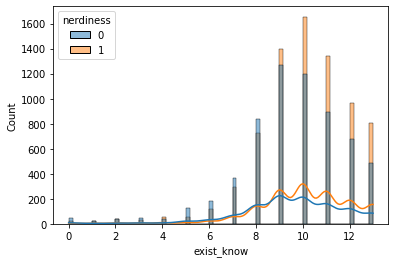

In [512]:
sns.histplot(tmp_frame[['exist_know','nerdiness']], x='exist_know', kde=True, hue='nerdiness')

+ introelapse Column 삭제

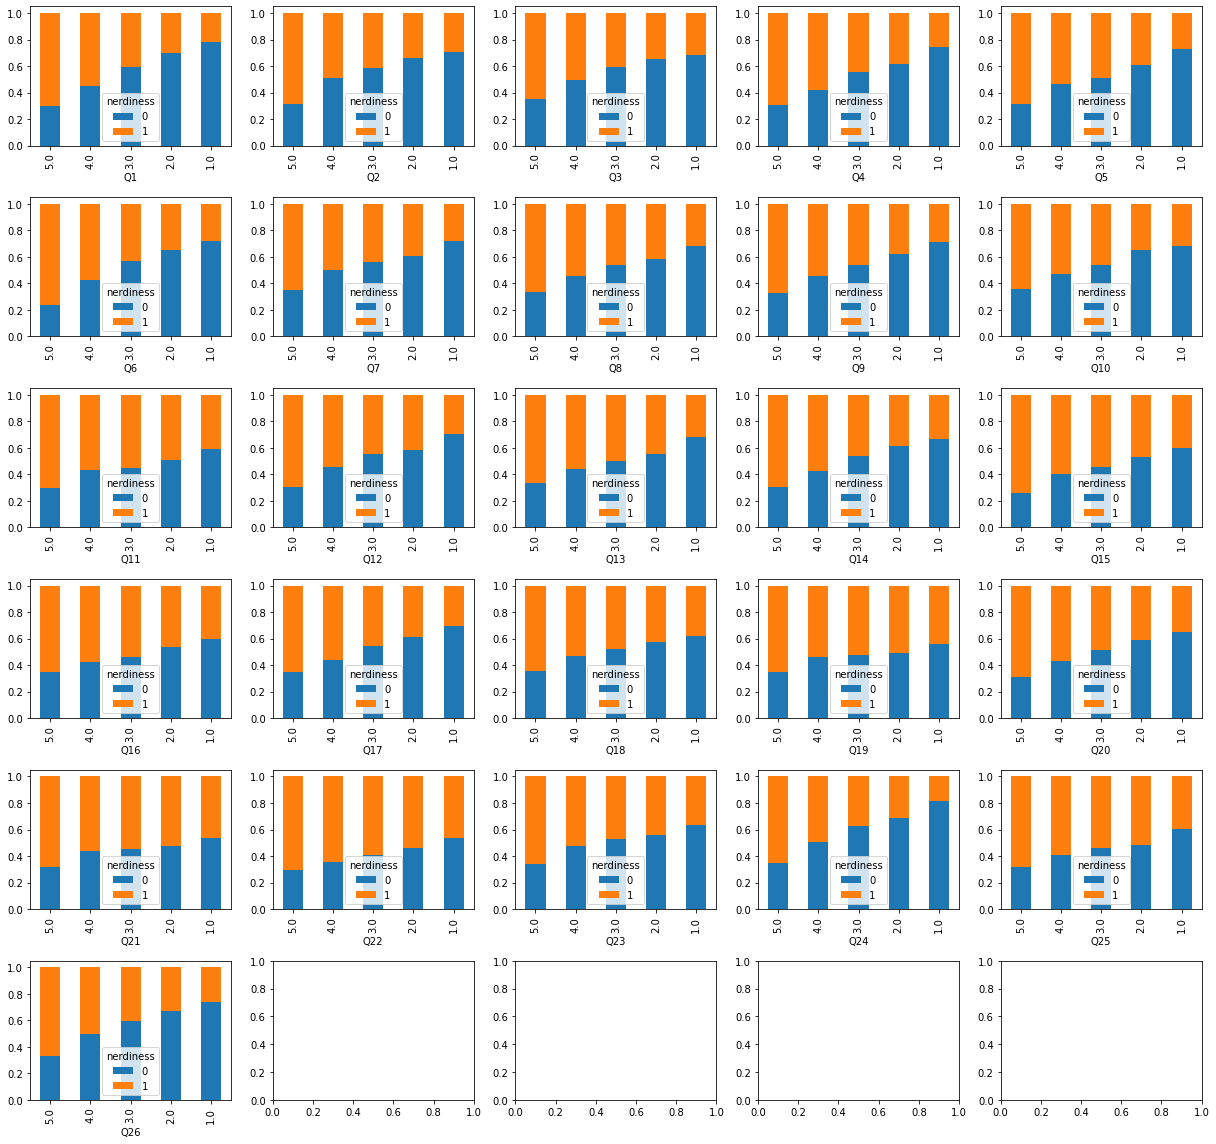

In [513]:
tmp_testQ = train[test_cols+['nerdiness']].dropna()
fig,axes = plt.subplots(6,5, figsize=(17,16))

for q_cols,ax in zip(test_cols, axes.ravel()):
    testQ_crosstab=pd.crosstab(tmp_testQ[q_cols],tmp_testQ['nerdiness'])
    testQ_ratio=ratio_table(testQ_crosstab)
    testQ_ratio=testQ_ratio.sort_values(by=0)
    
    testQ_ratio.plot(kind='bar', ax=ax,stacked=True)
    fig.tight_layout()

+ 26 개의 문항 모두, 응답 점수가 5에 가까울수록 Nerdiness 값이 1일 확률이 높음. 동시에,응답 점수가 1에 가까울 수록 Nerdiness 값이 0일 확률이 높으므로, 전체 26 개 문항에 대한 응답 점수의 평균을 관리하는 Column을 추가(최댓값, 최솟값의 범위를 더 좁히기 위함). 그리고, 26 개 문항에 대한 Column들은 모두 Drop.
+ 결측치의 경우, 결측 문항을 제외한 평균을 계산하여, 평균에 가까운 점수 입력

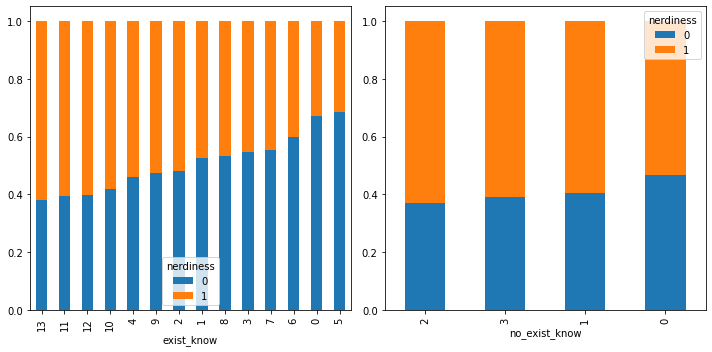

In [514]:
tmp_vcl = train[vcl_cols + ['nerdiness']].dropna()
tmp_vcl['exist_know'] = tmp_vcl[vcl_exist].sum(axis=1)          ## 안다고 체크한 단어의 개수
tmp_vcl['no_exist_know'] = tmp_vcl[vcl_no_exist].sum(axis=1)

fig,axes = plt.subplots(1,2, figsize=(10,5))

for is_know_cols,ax in zip(['exist_know', 'no_exist_know'], axes.ravel()):
    is_know_crosstab=pd.crosstab(tmp_vcl[is_know_cols],tmp_vcl['nerdiness'])
    is_know_ratio=ratio_table(is_know_crosstab)
    is_know_ratio=is_know_ratio.sort_values(by=0)
    
    is_know_ratio.plot(kind='bar', ax=ax,stacked=True)
    fig.tight_layout()

+ exist_know 는 포함시키도록 하자.

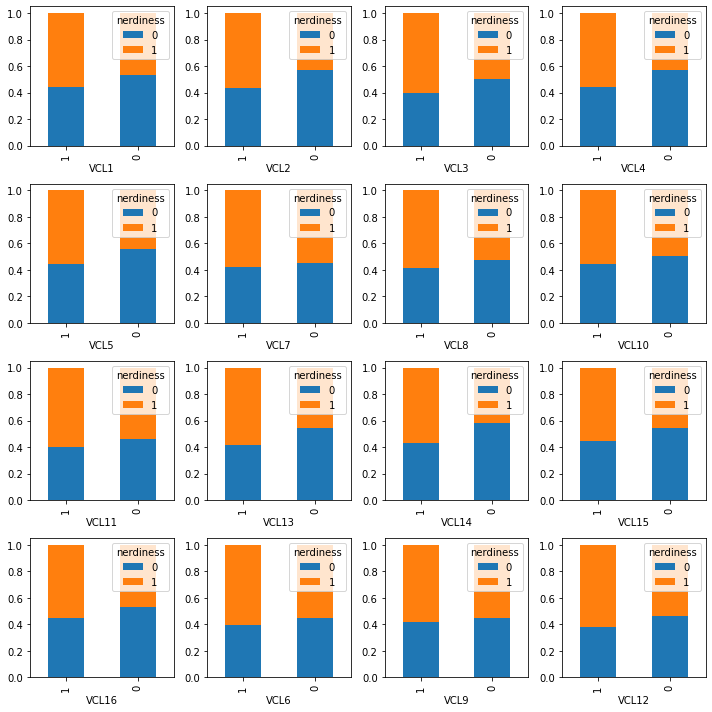

In [515]:
tmp_vcl = train[vcl_cols + ['nerdiness']].dropna()
fig,axes = plt.subplots(4,4, figsize=(10,10))

for wr_col,ax in zip(vcl_cols, axes.ravel()):
    wr_crosstab=pd.crosstab(tmp_vcl[wr_col],tmp_vcl['nerdiness'])
    wr_ratio=ratio_table(wr_crosstab)
    wr_ratio=wr_ratio.sort_values(by=0)
    
    wr_ratio.plot(kind='bar', ax=ax,stacked=True)
    fig.tight_layout()

+ vcl 1~16 Column 들은 학습 데이터에서 제외토록 하자.
  + Nerdiness 0,1 의 비율차이가 주어진 단어들을 아냐 모르냐에 따라 유의미하게 차이나지 않음
+ 아는 단어의 개수의 경우,10개 이상, 0개/5개, 그외 의 그룹으로 분류

+ 테스트/설문의 신뢰도의 경우, 실존하지 않는 단어들을 2 개 이상 안다고 체크한 사람들 중에서, testelapse, surveyelapse 가 자체적으로 설정한 하한보다 작은 경우, 신뢰성이 없다고 

In [15]:
droplist= test_cols + vcl_cols + tipi_cols + ['introelapse', 'age','familysize','index']

In [16]:
final_train = train.copy()

final_train = delRows(final_train)         ## 무의미한 이상치 가진 Row 제거 (테스트의 신뢰도 저해하는 Row)
final_train = subOutli(final_train)        ## 이상치 처리 
final_train = replaceNAN(final_train)      ## 결측치 처리
final_train = cat_age(final_train)         ## age 를 log 로 변환후, 범위에 따라 그룹화
final_train = cat_familysize(final_train)  ## familysize 를 범위에 따라 그룹화
cntry_groups_train = groupCntryCol(final_train)

final_train = cat_country(final_train,cntry_groups_train)
final_train = calcTIPI (final_train)      ## TIPI 점수 추가
final_train = calcTest (final_train)     ## 테스트 점수 추가

final_train = cat_Knowr(final_train)
final_train = one_hot_encoding(final_train)
final_train = stdize_cols(final_train)

final_train = final_train.drop(droplist,axis=1)

In [17]:
final_test = test.copy()
final_test = delRows(final_test)         ## 무의미한 이상치 가진 Row 제거 (테스트의 신뢰도 저해하는 Row)
final_test = subOutli(final_test)        ## 이상치 처리 
final_test = replaceNAN(final_test)      ## 결측치 처리
final_test = cat_age(final_test)         ## age 를 log 로 변환후, 범위에 따라 그룹화
final_test = cat_familysize(final_test)  ## familysize 를 범위에 따라 그룹화

tmp_cntrys =  cntry_groups_train[0] + cntry_groups_train[1] + cntry_groups_train[2] + cntry_groups_train[3]
tmp_cntry_grps = list(cntry_groups_train)
new_cntry = list(set(final_test['country'].unique()).difference(set(tmp_cntrys)))

cntry_groups_test = groupCntryTest(tmp_cntry_grps,new_cntry)
final_test = cat_country(final_test,cntry_groups_test)
final_test = calcTIPI (final_test)      ## TIPI 점수 추가
final_test = calcTest (final_test)     ## 테스트 점수 추가

final_test = cat_Knowr(final_test)
final_test = one_hot_encoding(final_test)
final_test = stdize_cols(final_test)


final_test = final_test.drop(droplist,axis=1)

In [18]:
train_x = final_train.drop(['nerdiness'],axis=1)
train_y = final_train[['nerdiness']]

In [19]:
test_x = final_test

In [20]:
train_x

,testelapse,surveyelapse,tp_extra,tp_agree,tp_consc,tp_emoti,tp_opens,test_score,country_0,country_1,...,familysize_group_4,familysize_group_5,age_loggroup_0,age_loggroup_1,age_loggroup_2,age_loggroup_3,education_1.0,education_2.0,education_3.0,education_4.0
1,-0.035800,-0.015506,5.0,5.5,5.0,2.5,4.5,3.269231,0,1,...,1,0,0,0,0,1,0,0,0,1
2,-0.033203,-0.015614,2.0,4.5,3.5,6.0,5.5,3.692308,0,1,...,1,0,0,0,1,0,0,1,0,0
3,-0.031734,-0.015404,4.0,4.5,3.5,3.5,5.0,3.500000,0,1,...,0,0,0,1,0,0,1,0,0,0
4,0.026880,-0.014990,3.5,4.0,4.0,3.5,5.0,3.461538,0,1,...,0,0,0,1,0,0,1,0,0,0
5,-0.034106,-0.015205,5.5,4.5,3.0,4.0,6.0,3.576923,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,-0.037946,0.417884,4.0,5.0,3.0,4.0,5.0,4.423077,0,1,...,0,1,0,0,1,0,0,0,1,0
14995,-0.033767,-0.015286,2.5,4.5,4.5,4.0,4.0,3.346154,0,1,...,0,0,0,1,0,0,0,1,0,0
14996,-0.033428,-0.015189,4.0,5.0,5.5,2.5,5.0,4.038462,0,1,...,0,0,0,0,1,0,0,0,0,1
14997,-0.033767,-0.015248,2.0,4.0,3.5,2.0,4.0,4.615385,0,1,...,0,0,0,1,0,0,0,1,0,0


In [21]:
test_x

,testelapse,surveyelapse,tp_extra,tp_agree,tp_consc,tp_emoti,tp_opens,test_score,country_0,country_1,...,familysize_group_4,familysize_group_5,age_loggroup_0,age_loggroup_1,age_loggroup_2,age_loggroup_3,education_1.0,education_2.0,education_3.0,education_4.0
1,-0.030235,-0.018995,2.0,3.5,4.0,3.0,5.5,4.307692,0,1,...,0,1,0,0,1,0,0,1,0,0
2,-0.032674,-0.019113,3.5,5.0,4.5,3.5,5.5,4.192308,0,1,...,0,0,1,0,0,0,1,0,0,0
4,-0.023406,-0.018338,3.5,4.0,3.5,3.0,4.5,4.076923,0,1,...,0,0,0,1,0,0,0,1,0,0
5,-0.022674,-0.018892,2.0,4.0,5.0,2.0,4.0,2.423077,0,1,...,0,0,0,1,0,0,0,1,0,0
6,-0.032674,-0.019477,4.5,4.5,3.0,4.0,5.0,3.730769,0,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35446,-0.033893,-0.019897,2.0,4.5,2.5,2.0,6.0,3.153846,0,1,...,0,0,0,1,0,0,1,0,0,0
35447,-0.018894,-0.018615,4.0,4.0,5.0,3.0,6.0,4.153846,0,1,...,0,0,0,1,0,0,0,1,0,0
35448,-0.026698,-0.019398,3.0,5.0,5.0,2.0,4.5,4.423077,0,1,...,0,0,0,1,0,0,0,1,0,0
35449,-0.028528,-0.019113,3.0,3.0,3.5,3.5,5.5,4.576923,0,1,...,0,0,0,0,1,0,0,0,1,0
